In [132]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from astropy.io import fits

from retrieval_base.spectrum import ModelSpectrum

%load_ext autoreload
%autoreload 2

path = pathlib.Path('/home/dario/phd/retrieval_base/')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
file = path / 'data' / 'PHOENIX' / 'lte02400-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
wave_file = path / 'data' / 'PHOENIX' / 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'

wave = fits.getdata(wave_file) # units in Angstroms
wave = wave / 10 # convert to nm

wmin, wmax = 2000., 5000.
mask = (wave > wmin) & (wave < wmax)
wave = wave[mask]

with fits.open(file) as hdul:
    print(hdul.info())
    hdr = hdul[0].header
    flux = hdul[0].data[mask] # units in erg/s/cm^2/cm
    
    
m_spec = ModelSpectrum(wave=wave, flux=flux)

rv = 0.0
vsini = 0.0
out_res = 3000.
m_spec.shift_broaden_rebin(
                    rv, 
                    vsini, 
                    epsilon_limb=0.5, 
                    out_res=out_res, 
                    in_res=1e6, 
                    d_wave=None, 
                    rebin=False, 
                    instr_broad_fast=False,
)

R = 2.7  # R_jup
d = 59.2 # pc
m_spec.scale_flux(R, d)

# convert from erg/s/cm^2/cm to erg/s/cm^2/nm
m_spec.flux *= 1e-7

Filename: /home/dario/phd/retrieval_base/data/PHOENIX/lte02400-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   (1569128,)   float32   
  1  ABUNDANCES    1 BinTableHDU     15   83R x 3C   [I, 2A, E]   
None


### Blackbody
- Emission coming from a single blackbody model representing the inner disk rim irradiated by the central source. 
$$
B(\lambda, T) = \frac{2hc^2}{\lambda^5} \frac{1}{e^{\frac{hc}{\lambda kT}} - 1}
$$


In [156]:
def blackbody_cgs(wave, T):
    h = 6.626e-27 # erg s
    c = 3.0e10 # cm/s
    k = 1.38e-16 # erg/K
    wave = wave * 1e-8 # convert from nm to cm
    
    # output units: erg/s/cm^2/cm/steradian
    # multiply by pi to get erg/s/cm^2/cm
    return np.pi * 2 * h * c**2 / wave**5 / (np.exp(h * c / wave / k / T) - 1)

T_bb = 1200.
R_bb = 1e3
bb = ModelSpectrum(wave=m_spec.wave, flux=blackbody_cgs(m_spec.wave, T_bb)*1e-7)
bb.scale_flux(R_bb, d)

m_spec_bb = m_spec + bb

In [165]:
# power law disk

log_r_0 = -18.5
r_0 = 10**log_r_0
alpha = 8
m_spec_pw = ModelSpectrum(wave=m_spec.wave, flux=r_0 * (m_spec.wave / wmin)**(alpha))

m_spec_disk_pw = m_spec + m_spec_pw

[Text(0.5, 0, 'Wavelength / nm'),
 Text(0, 0.5, 'Flux / erg/s/cm^2/cm'),
 (2000.0, 5000.0)]

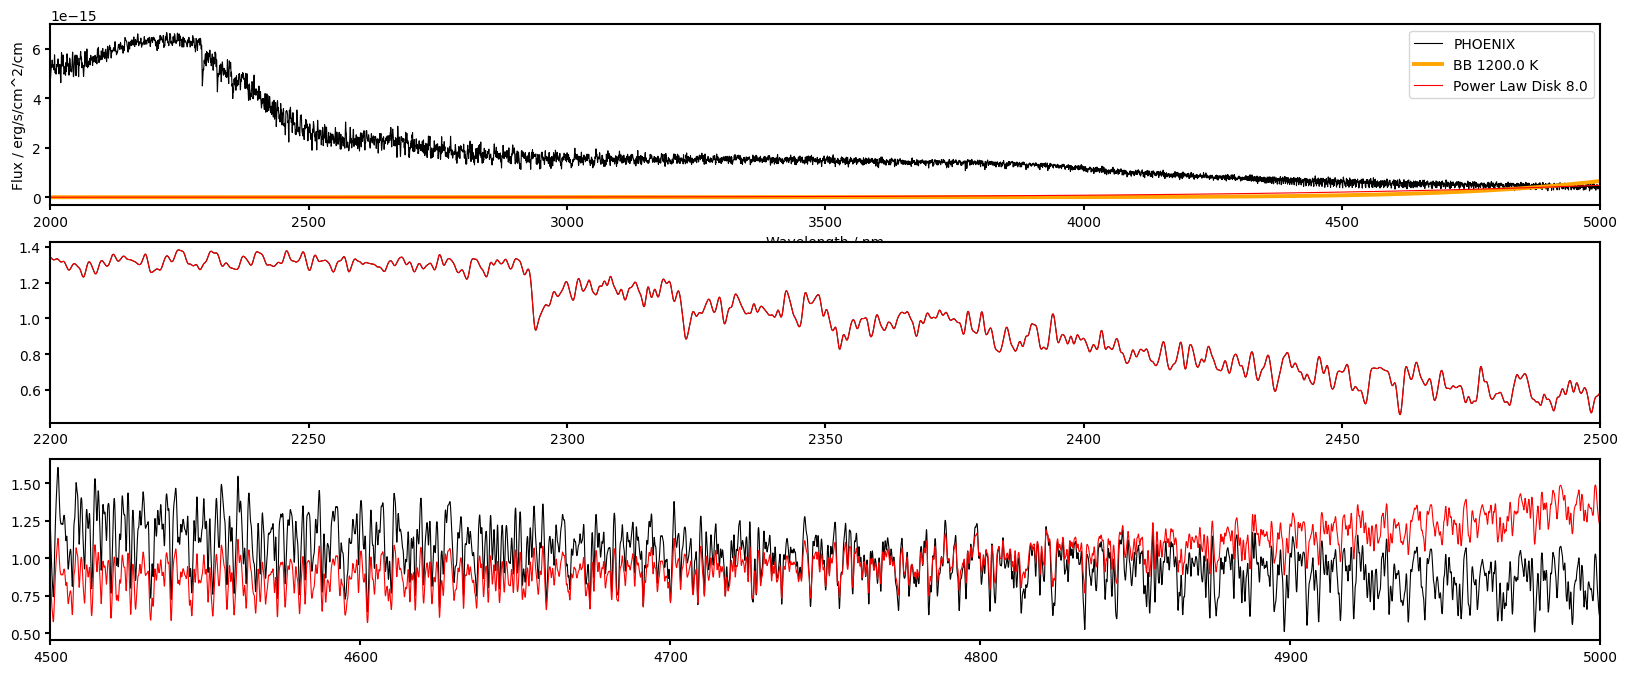

In [166]:
fig, ax = plt.subplots(3,1, figsize=(20,8))
# ax.plot(wave, flux)
ax[0].plot(m_spec.wave, m_spec.flux, lw=0.8, color='k', label='PHOENIX')
ax[0].plot(bb.wave, bb.flux, lw=2.8, color='orange', label=f'BB {T_bb} K')
ax[0].plot(m_spec_pw.wave, m_spec_pw.flux, lw=0.8, color='r', label=f'Power Law Disk {alpha:.1f}')
# plot K-band normalized flux

bands = {'K': (2200, 2500), 'M': (4500, 5000)}

for i, band in enumerate(bands.keys()):
    band_range = bands[band]
    band_mask = (m_spec.wave > band_range[0]) & (m_spec.wave < band_range[1])

    ax[i+1].plot(m_spec.wave[band_mask], m_spec.flux[band_mask] / np.mean(m_spec.flux[band_mask]), lw=0.8, label=f'PHOENIX {band}', color='k')
    ax[i+1].plot(m_spec_bb.wave[band_mask], m_spec_bb.flux[band_mask] / np.mean(m_spec_bb.flux[band_mask]), lw=0.8, label=f'PHOENIX+BB {band}', color='r')
    
    ax[i+1].set(xlim=(band_range[0], band_range[1]))
# k_band_flux = bb.flux[k_band_mask]
# k_band_flux /= np.mean(k_band_flux)
# ax[1].plot(bb.wave[k_band_mask], k_band_flux, lw=2.8, color='orange', label=f'BB {T_bb} K')

ax[0].legend()
ax[0].set(xlabel='Wavelength / nm', ylabel='Flux / erg/s/cm^2/cm', xlim=(wmin, wmax))